
# 3.5. Vignette for extracting Long Ids
**Reference Guided Isoform Discovery (Bulk)**

This vignettes can be used to extract reference gen and transcript Ids from Gffcompare results and map them back to transcript counts and reconstructed gtf for further analysis. It takes the Gffcompare tracking file, trasncript counts matrix and reconstructed strngtie GTF as an input and outputs the matrix and GTF replacing Stringtie Ids with Long Ids as below. 

**Long Id format:**
<br> Stringtie.Gene.Id^Stringtie.Transcript.Id^Reference.Gene.Id^Reference.Transcript.Id^GffcompareCode
eg: 

In [ ]:
# Uncomment the commands below to run this cell if using collab
#!git clone https://github.com/MethodsDev/kinnex-documentation-external.git
#!pip install -r kinnex-documentation-external/requirements.txt
# wd="kinnex-documentation-external/test_data/"

In [105]:
import os
import re
import glob
import pandas as pd
import numpy as np
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.options.display.max_colwidth = 100

## Matching gene and transcript ids from Gffcompare outs with Isoquant outs

In [7]:
!which conda

/Applications/anaconda2023/anaconda3/bin/conda


<h3>looking at the tracking file from gffcompare outs for matching ids </h4>

In [25]:
#Uncomment if using Binder Jupyter Lab Interface
wd="../test_data/"

In [27]:
colnames=["query_transfrag_id", "query_locus_id", "reference_gene_id","class_code","qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len"]
tracking_df = pd.read_csv(wd+'gffcmp.tracking', sep='\t',names=colnames, header=None)

In [14]:
print(tracking_df.shape)
tracking_df.head()


(25855, 5)


,query_transfrag_id,query_locus_id,reference_gene_id,class_code,qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len
0,TCONS_00000001,XLOC_000001,ENSG00000228794.11|ENST00000670780.1,j,q1:MSTRG.5|MSTRG.5.1|7|0.000000|0.000000|0.000000|3219
1,TCONS_00000002,XLOC_000001,ENSG00000228794.11|ENST00000445118.7,j,q1:MSTRG.5|MSTRG.5.2|6|0.000000|0.000000|0.000000|3060
2,TCONS_00000003,XLOC_000001,ENSG00000228794.11|ENST00000445118.7,j,q1:MSTRG.5|MSTRG.5.3|6|0.000000|0.000000|0.000000|3060
3,TCONS_00000004,XLOC_000002,ENSG00000187608.10|ENST00000649529.1,=,q1:MSTRG.6|MSTRG.6.1|2|0.000000|0.000000|0.000000|700
4,TCONS_00000005,XLOC_000003,ENSG00000217801.11|ENST00000456409.6,=,q1:MSTRG.8|MSTRG.8.1|4|0.000000|0.000000|0.000000|937


In [29]:
#col0 gene_ids qJ:gene_id
tracking_df["gene_id"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[0].split(':')[1])
#col1 transcript_id
tracking_df["transcript_id"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[1])
#col2 num_exons
tracking_df["num_exons"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[2])
#col3 FPKM
tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[3]).unique()
#col4 TPM
tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[4]).unique()
#col5 cov
tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[5]).unique()
#col6 len
tracking_df["len"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[6])

In [31]:
tracking_df=tracking_df[['query_transfrag_id','query_locus_id','reference_gene_id','class_code','gene_id','transcript_id','num_exons','len']]

In [33]:
tracking_df.transcript_id.unique().shape

(25855,)

In [35]:
tracking_df
#check - gffcompare matching at gene vs transcript level

,query_transfrag_id,query_locus_id,reference_gene_id,class_code,gene_id,transcript_id,num_exons,len
0,TCONS_00000001,XLOC_000001,ENSG00000228794.11|ENST00000670780.1,j,MSTRG.5,MSTRG.5.1,7,3219
1,TCONS_00000002,XLOC_000001,ENSG00000228794.11|ENST00000445118.7,j,MSTRG.5,MSTRG.5.2,6,3060
2,TCONS_00000003,XLOC_000001,ENSG00000228794.11|ENST00000445118.7,j,MSTRG.5,MSTRG.5.3,6,3060
3,TCONS_00000004,XLOC_000002,ENSG00000187608.10|ENST00000649529.1,=,MSTRG.6,MSTRG.6.1,2,700
4,TCONS_00000005,XLOC_000003,ENSG00000217801.11|ENST00000456409.6,=,MSTRG.8,MSTRG.8.1,4,937
...,...,...,...,...,...,...,...,...
25850,TCONS_00025851,XLOC_011477,ENSG00000131002.13|ENST00000693214.1,=,MSTRG.12167,MSTRG.12167.2,3,2533
25851,TCONS_00025852,XLOC_011477,ENSG00000131002.13|ENST00000253320.8,c,MSTRG.12166,MSTRG.12166.1,2,1820
25852,TCONS_00025853,XLOC_011478,ENSG00000198692.10|ENST00000361365.7,=,MSTRG.12169,MSTRG.12169.1,7,1392
25853,TCONS_00025854,XLOC_011479,ENSG00000012817.16|ENST00000541639.5,j,MSTRG.12168,MSTRG.12168.1,8,1527


### Looking at the distribution of class codes (similar to SQANTI)

<div class="xtable"><table frame="hsides" rules="groups" content-type="article-table" class="rendered small default_table"><thead><tr><th align="left" valign="top" rowspan="1" colspan="1">Code</th><th align="left" valign="top" rowspan="1" colspan="1">Relationship to reference transcript</th></tr></thead><tbody><tr><td align="left" valign="top" rowspan="1" colspan="1">=</td><td align="left" valign="top" rowspan="1" colspan="1">complete, exact intron chain match</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">c</td><td align="left" valign="top" rowspan="1" colspan="1">contained in reference transcript (intron compatible)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">k</td><td align="left" valign="top" rowspan="1" colspan="1">contains reference transcript (reverse containment)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">m</td><td align="left" valign="top" rowspan="1" colspan="1">retained intron(s) compared to reference, full intron chain match
<br>everywhere else</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">n</td><td align="left" valign="top" rowspan="1" colspan="1">completely overlaps intron from reference transcript, partial or no intron
<br>chain match everywhere else</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">j</td><td align="left" valign="top" rowspan="1" colspan="1">multi-exon with at least one junction match</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">e</td><td align="left" valign="top" rowspan="1" colspan="1">single exon that partially covers an intron from reference</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">o</td><td align="left" valign="top" rowspan="1" colspan="1">other same strand overlap with reference exons</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">s</td><td align="left" valign="top" rowspan="1" colspan="1">intron match on the opposite strand (likely a mapping error)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">x</td><td align="left" valign="top" rowspan="1" colspan="1">exonic overlap on the opposite strand</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">i</td><td align="left" valign="top" rowspan="1" colspan="1">fully contained within a reference intron</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">y</td><td align="left" valign="top" rowspan="1" colspan="1">contains a reference within its intron(s)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">p</td><td align="left" valign="top" rowspan="1" colspan="1">possible polymerase run-on (close to reference but no overlap)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">r</td><td align="left" valign="top" rowspan="1" colspan="1">repeat (at least 50% bases are soft-masked)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">u</td><td align="left" valign="top" rowspan="1" colspan="1">none of the above (unknown, intergenic)</td></tr></tbody></table></div>

[Text(0.5, 1.0, 'Distribution of class codes - Gffcompare \n Ref Guided track Bulk Kinnex ')]

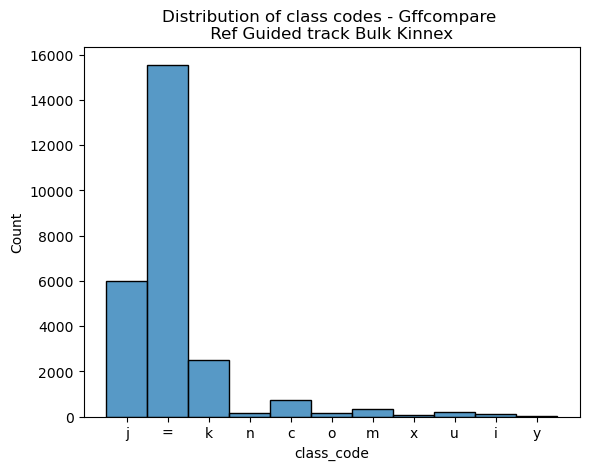

In [38]:
sns.histplot(tracking_df.class_code).set(title='Distribution of class codes - Gffcompare \n Ref Guided track Bulk Kinnex ')

<h5>We have combined count matrix, generated with Isoquant in Quantification mode, quantifying against a reconstrutced gtf - stringtie_merged.gtf </h5>

In [40]:
isoquant_counts_df = pd.read_csv(wd+'/refGuided_isoquants_quantify_combined_trancripts_counts_matrix.tsv', sep='\t')
isoquant_counts_df.head(5)


,#feature_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2
0,MSTRG.1.1,13.0,12.0,0.0,12.0,8.0,23.0
1,MSTRG.10.1,11.0,9.0,13.0,0.0,0.0,0.0
2,MSTRG.100.1,7.0,0.0,0.0,0.0,0.0,0.0
3,MSTRG.1000.1,19.0,12.0,14.0,0.0,0.0,0.0
4,MSTRG.10000.1,10.0,6.0,0.0,9.0,5.0,1.0


In [42]:
isoquant_counts_df.shape

(25858, 7)

In [44]:
isoquant_counts_df.rename(columns={'#feature_id': 'isoform_id'}, inplace=True)

In [46]:
tracking_df[['reference_gene_id','class_code','transcript_id']]

,reference_gene_id,class_code,transcript_id
0,ENSG00000228794.11|ENST00000670780.1,j,MSTRG.5.1
1,ENSG00000228794.11|ENST00000445118.7,j,MSTRG.5.2
2,ENSG00000228794.11|ENST00000445118.7,j,MSTRG.5.3
3,ENSG00000187608.10|ENST00000649529.1,=,MSTRG.6.1
4,ENSG00000217801.11|ENST00000456409.6,=,MSTRG.8.1
...,...,...,...
25850,ENSG00000131002.13|ENST00000693214.1,=,MSTRG.12167.2
25851,ENSG00000131002.13|ENST00000253320.8,c,MSTRG.12166.1
25852,ENSG00000198692.10|ENST00000361365.7,=,MSTRG.12169.1
25853,ENSG00000012817.16|ENST00000541639.5,j,MSTRG.12168.1


In [48]:
print(isoquant_counts_df.shape)
# 59734 
isoquant_counts_df[isoquant_counts_df.isoform_id.str.contains('_')]

(25858, 7)


,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2
25855,__ambiguous,79394.0,83787.0,87926.0,57756.0,58032.0,64008.0
25856,__no_feature,156360.0,154770.0,159054.0,42323.0,43680.0,47408.0
25857,__not_aligned,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
isoquant_wRefids=isoquant_counts_df[~isoquant_counts_df.isoform_id.str.contains('_')].merge(tracking_df[['reference_gene_id','class_code','transcript_id']], \
                         how='left', left_on='isoform_id', right_on='transcript_id')

In [52]:
isoquant_wRefids.loc[isoquant_wRefids.isoform_id.isin(['MSTRG.5415.3','MSTRG.12284.4', 
                                                       'MSTRG.6514.2','MSTRG.6514.1',
                                                       'MSTRG.18675.1','MSTRG.19411.3'])]

,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2,reference_gene_id,class_code,transcript_id
17596,MSTRG.6514.1,6.5,7.5,13.0,6.0,9.0,8.5,ENSG00000198369.10|ENST00000356388.9,=,MSTRG.6514.1
17597,MSTRG.6514.2,7.5,6.5,0.0,0.0,0.0,0.0,ENSG00000198369.10|ENST00000443619.6,=,MSTRG.6514.2


In [54]:
print(isoquant_wRefids.shape)

(25855, 10)


In [56]:
#print(isoquant_wRefids.reference_gene_id.head(10))
#print(isoquant_wRefids.reference_gene_id.apply(lambda x: x.split('|')[-1]).head(10))
#print(isoquant_wRefids.reference_gene_id.apply(lambda x: x.split('|')[0]).head(10))

isoquant_wRefids[['ref_gene_id','ref_transcript_id']]=\
isoquant_wRefids['reference_gene_id'].str.split('|',expand=True)


In [58]:
print(isoquant_wRefids.loc[isoquant_wRefids['reference_gene_id']!='-',].shape)
isoquant_wRefids.loc[isoquant_wRefids['reference_gene_id']!='-',]

(25661, 12)


,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2,reference_gene_id,class_code,transcript_id,ref_gene_id,ref_transcript_id
0,MSTRG.1.1,13.0,12.0,0.0,12.0,8.0,23.0,ENSG00000278267.1|ENST00000619216.1,k,MSTRG.1.1,ENSG00000278267.1,ENST00000619216.1
1,MSTRG.10.1,11.0,9.0,13.0,0.0,0.0,0.0,ENSG00000186891.14|ENST00000379268.7,=,MSTRG.10.1,ENSG00000186891.14,ENST00000379268.7
2,MSTRG.100.1,7.0,0.0,0.0,0.0,0.0,0.0,ENSG00000276470.1|ENST00000622391.1,k,MSTRG.100.1,ENSG00000276470.1,ENST00000622391.1
3,MSTRG.1000.1,19.0,12.0,14.0,0.0,0.0,0.0,ENSG00000116667.15|ENST00000235307.7,=,MSTRG.1000.1,ENSG00000116667.15,ENST00000235307.7
4,MSTRG.10000.1,10.0,6.0,0.0,9.0,5.0,1.0,ENSG00000085382.12|ENST00000262903.9,=,MSTRG.10000.1,ENSG00000085382.12,ENST00000262903.9
...,...,...,...,...,...,...,...,...,...,...,...,...
25850,MSTRG.9996.2,0.0,0.0,3.0,8.0,0.0,8.0,ENSG00000123552.18|ENST00000472914.6,=,MSTRG.9996.2,ENSG00000123552.18,ENST00000472914.6
25851,MSTRG.9997.1,12.0,17.0,20.0,13.0,8.0,12.0,ENSG00000112249.14|ENST00000369143.2,=,MSTRG.9997.1,ENSG00000112249.14,ENST00000369143.2
25852,MSTRG.9998.1,7.0,11.0,10.0,27.0,38.0,30.0,ENSG00000187772.8|ENST00000345080.5,=,MSTRG.9998.1,ENSG00000187772.8,ENST00000345080.5
25853,MSTRG.9999.1,9.5,8.0,3.5,8.0,3.5,11.0,ENSG00000132429.10|ENST00000474760.1,=,MSTRG.9999.1,ENSG00000132429.10,ENST00000474760.1


In [62]:
isoquant_wRefids=isoquant_wRefids[['transcript_id','ref_gene_id','ref_transcript_id','class_code',\
                  'HG002_E0','HG002_E0','HG002_E2','K562_E0','K562_E1','K562_E2']]

In [64]:
isoquant_wRefids.to_csv(wd+'isoquant_counts_mapped.tsv', sep='\t')

In [66]:
print(isoquant_wRefids.shape)
isoquant_wRefids.head()

(25855, 10)


,transcript_id,ref_gene_id,ref_transcript_id,class_code,HG002_E0,HG002_E0,HG002_E2,K562_E0,K562_E1,K562_E2
0,MSTRG.1.1,ENSG00000278267.1,ENST00000619216.1,k,13.0,13.0,0.0,12.0,8.0,23.0
1,MSTRG.10.1,ENSG00000186891.14,ENST00000379268.7,=,11.0,11.0,13.0,0.0,0.0,0.0
2,MSTRG.100.1,ENSG00000276470.1,ENST00000622391.1,k,7.0,7.0,0.0,0.0,0.0,0.0
3,MSTRG.1000.1,ENSG00000116667.15,ENST00000235307.7,=,19.0,19.0,14.0,0.0,0.0,0.0
4,MSTRG.10000.1,ENSG00000085382.12,ENST00000262903.9,=,10.0,10.0,0.0,9.0,5.0,1.0


In [60]:
isoquant_wRefids['strgt_gene_ids']=\
isoquant_wRefids.transcript_id.apply(lambda x: ('.').join(x.split('.')[0:2]))

In [62]:
(isoquant_wRefids[['ref_gene_id','strgt_gene_ids']]\
 .groupby('strgt_gene_ids')['ref_gene_id'].nunique())

strgt_gene_ids
MSTRG.1        1
MSTRG.10       1
MSTRG.100      1
MSTRG.1000     1
MSTRG.10000    1
              ..
MSTRG.9995     1
MSTRG.9996     1
MSTRG.9997     1
MSTRG.9998     1
MSTRG.9999     1
Name: ref_gene_id, Length: 12170, dtype: int64

<br>**Gffcompare may assign distinct Reference Genes and Transcripts to the same Stringtie Gene Ids. We would want to preserve that assignemnt. 
<br>Here in this sub-section we explore these cases.**

In [67]:
stringtie_gene_id_counts=isoquant_wRefids.groupby('strgt_gene_ids').agg({'ref_gene_id':lambda x: len(pd.unique(x))})

In [69]:
stringtie_gene_id_counts=stringtie_gene_id_counts.add_suffix('_Count').reset_index()

In [71]:
stringtie_gene_id_counts

,strgt_gene_ids,ref_gene_id_Count
0,MSTRG.1,1
1,MSTRG.10,1
2,MSTRG.100,1
3,MSTRG.1000,1
4,MSTRG.10000,1
...,...,...
12165,MSTRG.9995,1
12166,MSTRG.9996,1
12167,MSTRG.9997,1
12168,MSTRG.9998,1


In [73]:
len(isoquant_wRefids.loc\
[isoquant_wRefids.strgt_gene_ids.isin(stringtie_gene_id_counts[stringtie_gene_id_counts.ref_gene_id_Count>1].strgt_gene_ids)]\
.strgt_gene_ids.unique())

178

In [75]:
isoquant_wRefids.loc\
[isoquant_wRefids.strgt_gene_ids.isin(stringtie_gene_id_counts[stringtie_gene_id_counts.ref_gene_id_Count>1].strgt_gene_ids),\
 ['strgt_gene_ids','transcript_id','ref_gene_id','ref_transcript_id','class_code']]

,strgt_gene_ids,transcript_id,ref_gene_id,ref_transcript_id,class_code
395,MSTRG.10180,MSTRG.10180.1,ENSG00000026297.17,ENST00000508775.6,=
396,MSTRG.10180,MSTRG.10180.2,ENSG00000026297.17,ENST00000683770.1,=
397,MSTRG.10180,MSTRG.10180.3,ENSG00000026297.17,ENST00000366855.10,j
398,MSTRG.10180,MSTRG.10180.4,ENSG00000026297.17,ENST00000682498.1,j
399,MSTRG.10180,MSTRG.10180.5,ENSG00000026297.17,ENST00000496851.6,k
...,...,...,...,...,...
25686,MSTRG.9924,MSTRG.9924.2,ENSG00000112245.13,ENST00000639568.2,k
25687,MSTRG.9924,MSTRG.9924.3,ENSG00000285976.2,ENST00000370651.7,=
25728,MSTRG.9948,MSTRG.9948.1,ENSG00000287811.2,ENST00000691944.1,=
25729,MSTRG.9948,MSTRG.9948.2,ENSG00000198478.8,ENST00000369838.6,j


In [77]:
len(isoquant_wRefids.transcript_id.unique())

25855

In [79]:
len(isoquant_wRefids.ref_transcript_id.unique())

20953

In [81]:
len(isoquant_wRefids.loc[isoquant_wRefids.\
                     duplicated(subset=['ref_transcript_id'])].ref_transcript_id.unique())

3370

In [83]:
isoquant_wRefids.loc[isoquant_wRefids.\
                     duplicated(subset=['ref_transcript_id'])].sort_values(by=['ref_transcript_id'])


,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2,reference_gene_id,class_code,transcript_id,ref_gene_id,ref_transcript_id,strgt_gene_ids
8129,MSTRG.2488.4,0.0,0.0,12.58,0.00,0.00,0.00,ENSG00000003056.8|ENST00000000412.8,n,MSTRG.2488.4,ENSG00000003056.8,ENST00000000412.8,MSTRG.2488
8128,MSTRG.2488.3,0.0,0.0,0.00,0.00,0.00,4.50,ENSG00000003056.8|ENST00000000412.8,j,MSTRG.2488.3,ENSG00000003056.8,ENST00000000412.8,MSTRG.2488
7971,MSTRG.2417.2,0.0,0.0,0.00,13.83,0.00,0.00,ENSG00000004478.8|ENST00000001008.6,j,MSTRG.2417.2,ENSG00000004478.8,ENST00000001008.6,MSTRG.2417
259,MSTRG.10121.2,0.0,0.0,8.33,6.83,9.83,8.17,ENSG00000001036.14|ENST00000002165.11,j,MSTRG.10121.2,ENSG00000001036.14,ENST00000002165.11,MSTRG.10121
7730,MSTRG.2310.2,9.5,7.0,0.00,8.50,0.00,5.00,ENSG00000048028.11|ENST00000003302.8,j,MSTRG.2310.2,ENSG00000048028.11,ENST00000003302.8,MSTRG.2310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24012,MSTRG.9231.1,1.0,0.0,0.00,0.00,6.00,5.00,-,u,MSTRG.9231.1,-,None,MSTRG.9231
24600,MSTRG.9485.1,0.0,0.0,0.00,0.00,2.00,0.00,-,u,MSTRG.9485.1,-,None,MSTRG.9485
24958,MSTRG.9623.1,0.0,2.0,3.00,0.00,0.00,0.00,-,u,MSTRG.9623.1,-,None,MSTRG.9623
25521,MSTRG.9853.1,2.0,0.0,0.00,1.00,0.00,0.00,-,u,MSTRG.9853.1,-,None,MSTRG.9853


In [41]:
isoquant_wRefids.loc[isoquant_wRefids.\
                     duplicated(subset=['ref_transcript_id'])].groupby(['class_code']).size()


class_code
=     1997
c      511
e      136
i     5381
j    11898
k     1241
m     1225
n      509
o      400
p       51
s        2
u     2872
x      724
y       11
dtype: int64

In [87]:
isoquant_wRefids=isoquant_wRefids.fillna(value="")

In [89]:
isoquant_wRefids['isoform_id']=isoquant_wRefids[['transcript_id', 'ref_gene_id', 'ref_transcript_id','class_code']]\
.agg('^'.join, axis=1)

In [95]:
isoquant_wRefids.head(5)

,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2,reference_gene_id,class_code,transcript_id,ref_gene_id,ref_transcript_id,strgt_gene_ids
0,MSTRG.1.1^ENSG00000278267.1^ENST00000619216.1^k,13.0,12.0,0.0,12.0,8.0,23.0,ENSG00000278267.1|ENST00000619216.1,k,MSTRG.1.1,ENSG00000278267.1,ENST00000619216.1,MSTRG.1
1,MSTRG.10.1^ENSG00000186891.14^ENST00000379268.7^=,11.0,9.0,13.0,0.0,0.0,0.0,ENSG00000186891.14|ENST00000379268.7,=,MSTRG.10.1,ENSG00000186891.14,ENST00000379268.7,MSTRG.10
2,MSTRG.100.1^ENSG00000276470.1^ENST00000622391.1^k,7.0,0.0,0.0,0.0,0.0,0.0,ENSG00000276470.1|ENST00000622391.1,k,MSTRG.100.1,ENSG00000276470.1,ENST00000622391.1,MSTRG.100
3,MSTRG.1000.1^ENSG00000116667.15^ENST0000023530...,19.0,12.0,14.0,0.0,0.0,0.0,ENSG00000116667.15|ENST00000235307.7,=,MSTRG.1000.1,ENSG00000116667.15,ENST00000235307.7,MSTRG.1000
4,MSTRG.10000.1^ENSG00000085382.12^ENST000002629...,10.0,6.0,0.0,9.0,5.0,1.0,ENSG00000085382.12|ENST00000262903.9,=,MSTRG.10000.1,ENSG00000085382.12,ENST00000262903.9,MSTRG.10000


In [101]:
isoquant_wRefids['isoform_id']=isoquant_wRefids.isoform_id.str.replace("=", "eq")

In [109]:
isoquant_wRefids.loc[isoquant_wRefids['class_code']=="=",].head(3)

,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2,reference_gene_id,class_code,transcript_id,ref_gene_id,ref_transcript_id,strgt_gene_ids
1,MSTRG.10.1^ENSG00000186891.14^ENST00000379268.7^eq,11.0,9.0,13.0,0.0,0.0,0.0,ENSG00000186891.14|ENST00000379268.7,=,MSTRG.10.1,ENSG00000186891.14,ENST00000379268.7,MSTRG.10
3,MSTRG.1000.1^ENSG00000116667.15^ENST00000235307.7^eq,19.0,12.0,14.0,0.0,0.0,0.0,ENSG00000116667.15|ENST00000235307.7,=,MSTRG.1000.1,ENSG00000116667.15,ENST00000235307.7,MSTRG.1000
4,MSTRG.10000.1^ENSG00000085382.12^ENST00000262903.9^eq,10.0,6.0,0.0,9.0,5.0,1.0,ENSG00000085382.12|ENST00000262903.9,=,MSTRG.10000.1,ENSG00000085382.12,ENST00000262903.9,MSTRG.10000


In [111]:
isoquant_counts_combined_wRefids=isoquant_wRefids[['isoform_id',\
                  'HG002_E0','HG002_E1','HG002_E2','K562_E0','K562_E1','K562_E2']]

In [113]:
isoquant_counts_combined_wRefids.head(5)

,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2
0,MSTRG.1.1^ENSG00000278267.1^ENST00000619216.1^k,13.0,12.0,0.0,12.0,8.0,23.0
1,MSTRG.10.1^ENSG00000186891.14^ENST00000379268.7^eq,11.0,9.0,13.0,0.0,0.0,0.0
2,MSTRG.100.1^ENSG00000276470.1^ENST00000622391.1^k,7.0,0.0,0.0,0.0,0.0,0.0
3,MSTRG.1000.1^ENSG00000116667.15^ENST00000235307.7^eq,19.0,12.0,14.0,0.0,0.0,0.0
4,MSTRG.10000.1^ENSG00000085382.12^ENST00000262903.9^eq,10.0,6.0,0.0,9.0,5.0,1.0


In [115]:
isoquant_counts_combined_wRefids.to_csv(\
    wd+'/isoquant_counts_combined_wRefids.tsv', \
     sep='\t') 


<h3>Updating the gtf with Ref Ensemble ids</h3>

In [121]:
gtf_f=wd+'stringtie_merged.gtf'
# as PyRanges-object
gr_obj = pr.read_gtf(gtf_f)

/Applications/anaconda2023/anaconda3/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [123]:
gr_df=gr_obj.df

In [125]:
print(gr_df.shape)
gr_df.head()
# 244000 number of unique transcripts from gffcompare tracking file

(244000, 11)


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,exon_number
0,chr1,StringTie,transcript,827597,855945,1000,+,.,MSTRG.5,MSTRG.5.1,NaN
1,chr1,StringTie,exon,827597,827775,1000,+,.,MSTRG.5,MSTRG.5.1,1
2,chr1,StringTie,exon,829002,829104,1000,+,.,MSTRG.5,MSTRG.5.1,2
3,chr1,StringTie,exon,847653,847806,1000,+,.,MSTRG.5,MSTRG.5.1,3
4,chr1,StringTie,exon,851926,852110,1000,+,.,MSTRG.5,MSTRG.5.1,4


In [127]:
gr_df[gr_df.Feature=='transcript'].transcript_id.unique().shape
# 25855 transcripts in gtf 

(25855,)

In [135]:
#MSTRG.5
gr_df.loc[gr_df['gene_id']=='MSTRG.5',].transcript_id.unique()

array(['MSTRG.5.1', 'MSTRG.5.2', 'MSTRG.5.3'], dtype=object)

In [137]:
print(isoquant_wRefids.shape)
isoquant_wRefids.head()

(25855, 13)


,isoform_id,HG002_E0,HG002_E1,HG002_E2,K562_E0,K562_E1,K562_E2,reference_gene_id,class_code,transcript_id,ref_gene_id,ref_transcript_id,strgt_gene_ids
0,MSTRG.1.1^ENSG00000278267.1^ENST00000619216.1^k,13.0,12.0,0.0,12.0,8.0,23.0,ENSG00000278267.1|ENST00000619216.1,k,MSTRG.1.1,ENSG00000278267.1,ENST00000619216.1,MSTRG.1
1,MSTRG.10.1^ENSG00000186891.14^ENST00000379268.7^eq,11.0,9.0,13.0,0.0,0.0,0.0,ENSG00000186891.14|ENST00000379268.7,=,MSTRG.10.1,ENSG00000186891.14,ENST00000379268.7,MSTRG.10
2,MSTRG.100.1^ENSG00000276470.1^ENST00000622391.1^k,7.0,0.0,0.0,0.0,0.0,0.0,ENSG00000276470.1|ENST00000622391.1,k,MSTRG.100.1,ENSG00000276470.1,ENST00000622391.1,MSTRG.100
3,MSTRG.1000.1^ENSG00000116667.15^ENST00000235307.7^eq,19.0,12.0,14.0,0.0,0.0,0.0,ENSG00000116667.15|ENST00000235307.7,=,MSTRG.1000.1,ENSG00000116667.15,ENST00000235307.7,MSTRG.1000
4,MSTRG.10000.1^ENSG00000085382.12^ENST00000262903.9^eq,10.0,6.0,0.0,9.0,5.0,1.0,ENSG00000085382.12|ENST00000262903.9,=,MSTRG.10000.1,ENSG00000085382.12,ENST00000262903.9,MSTRG.10000


In [139]:
gr_wRefids=gr_df.merge(\
    isoquant_wRefids[['transcript_id','strgt_gene_ids','ref_gene_id','ref_transcript_id','isoform_id','class_code']],\
    how='left', on='transcript_id')


In [141]:
print(gr_wRefids.shape)
gr_wRefids.head(5)
# 7618 transcript ids in the gtf do not exist in isoquant results.

(244000, 16)


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,exon_number,strgt_gene_ids,ref_gene_id,ref_transcript_id,isoform_id,class_code
0,chr1,StringTie,transcript,827597,855945,1000,+,.,MSTRG.5,MSTRG.5.1,NaN,MSTRG.5,ENSG00000228794.11,ENST00000670780.1,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j,j
1,chr1,StringTie,exon,827597,827775,1000,+,.,MSTRG.5,MSTRG.5.1,1,MSTRG.5,ENSG00000228794.11,ENST00000670780.1,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j,j
2,chr1,StringTie,exon,829002,829104,1000,+,.,MSTRG.5,MSTRG.5.1,2,MSTRG.5,ENSG00000228794.11,ENST00000670780.1,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j,j
3,chr1,StringTie,exon,847653,847806,1000,+,.,MSTRG.5,MSTRG.5.1,3,MSTRG.5,ENSG00000228794.11,ENST00000670780.1,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j,j
4,chr1,StringTie,exon,851926,852110,1000,+,.,MSTRG.5,MSTRG.5.1,4,MSTRG.5,ENSG00000228794.11,ENST00000670780.1,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j,j


In [143]:
gr_wRefids[['ref_transcript_id','class_code']].groupby(['class_code']).size()

class_code
=    149969
c      6148
i       365
j     53655
k     28645
m      2566
n      1071
o       432
u       791
x       317
y        41
dtype: int64

In [145]:
gr_wRefids[gr_wRefids['ref_transcript_id']==""].groupby(['class_code']).size()

class_code
u    791
dtype: int64

In [149]:
gr_wRefids=gr_wRefids.rename(columns={
    'strgt_gene_ids':'mstrg_gene',
    'transcript_id':'mstrg_transcript',
    'isoform_id':'transcript_id',
    'ref_gene_id': 'ensmb_gene',
    'ref_transcript_id':'ensmb_transcript'})


In [153]:
len(gr_wRefids[gr_wRefids['transcript_id'].isnull()])

0

In [155]:
gr_wRefids['transcript_id']=gr_wRefids['transcript_id'].fillna("")

In [159]:
len(gr_wRefids.loc[(gr_wRefids['class_code']=='u') & (gr_wRefids['Feature']=='transcript'),])

194

In [175]:
gr_wRefids=gr_wRefids.drop(['mstrg_gene','mstrg_transcript','ensmb_gene',\
                            'ensmb_transcript','class_code'], axis=1)


In [177]:
gr_wRefids.head(10)

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,exon_number,transcript_id
0,chr1,StringTie,transcript,827597,855945,1000,+,.,MSTRG.5,NaN,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
1,chr1,StringTie,exon,827597,827775,1000,+,.,MSTRG.5,1,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
2,chr1,StringTie,exon,829002,829104,1000,+,.,MSTRG.5,2,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
3,chr1,StringTie,exon,847653,847806,1000,+,.,MSTRG.5,3,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
4,chr1,StringTie,exon,851926,852110,1000,+,.,MSTRG.5,4,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
5,chr1,StringTie,exon,852670,852766,1000,+,.,MSTRG.5,5,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
6,chr1,StringTie,exon,853390,853478,1000,+,.,MSTRG.5,6,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
7,chr1,StringTie,exon,853527,855945,1000,+,.,MSTRG.5,7,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
8,chr1,StringTie,transcript,827603,855945,1000,+,.,MSTRG.5,NaN,MSTRG.5.2^ENSG00000228794.11^ENST00000445118.7^j
9,chr1,StringTie,exon,827603,827775,1000,+,.,MSTRG.5,1,MSTRG.5.2^ENSG00000228794.11^ENST00000445118.7^j


### Writing gtf - replacing transcript Ids in strtingtie GTF with Long Ids

In [180]:
 gr_wRefids_pr= pr.PyRanges(gr_wRefids)

/Applications/anaconda2023/anaconda3/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [182]:
gr_wRefids_pr.head()


/Applications/anaconda2023/anaconda3/lib/python3.11/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  empty_removed = df.groupby(["Chromosome", "Strand"])


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,exon_number,transcript_id
0,chr1,StringTie,transcript,827597,855945,1000,+,.,MSTRG.5,NaN,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
1,chr1,StringTie,exon,827597,827775,1000,+,.,MSTRG.5,1,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
2,chr1,StringTie,exon,829002,829104,1000,+,.,MSTRG.5,2,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
3,chr1,StringTie,exon,847653,847806,1000,+,.,MSTRG.5,3,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
4,chr1,StringTie,exon,851926,852110,1000,+,.,MSTRG.5,4,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
5,chr1,StringTie,exon,852670,852766,1000,+,.,MSTRG.5,5,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
6,chr1,StringTie,exon,853390,853478,1000,+,.,MSTRG.5,6,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j
7,chr1,StringTie,exon,853527,855945,1000,+,.,MSTRG.5,7,MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j


In [184]:
gr_wRefids_pr.to_gtf(\
   wd+"stringtie_merged.wRefIds.gtf")

In [188]:
#! cat stringtie_merged.wRefIds.gtf | head -5

chr1	StringTie	transcript	827598	855945	1000	+	.	gene_id "MSTRG.5"; transcript_id "MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j";
chr1	StringTie	exon	827598	827775	1000	+	.	gene_id "MSTRG.5"; exon_number "1"; transcript_id "MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j";
chr1	StringTie	exon	829003	829104	1000	+	.	gene_id "MSTRG.5"; exon_number "2"; transcript_id "MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j";
chr1	StringTie	exon	847654	847806	1000	+	.	gene_id "MSTRG.5"; exon_number "3"; transcript_id "MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j";
chr1	StringTie	exon	851927	852110	1000	+	.	gene_id "MSTRG.5"; exon_number "4"; transcript_id "MSTRG.5.1^ENSG00000228794.11^ENST00000670780.1^j";
cat: stdout: Broken pipe
